<a href="https://colab.research.google.com/github/crossmodaldebate/app/blob/main/io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório criado: /content/drive/MyDrive/graficos


# Análise da Manutenção Descentralizada de Indicadores do Ideb (Crossmodal Debate)

## Dados Carregados

  escola_id   ano  ideb  participacao_comunidade  implementacao_acoes regiao  \
0         1  2018   4.8                     0.30                    0  Norte   
1         1  2019   4.9                     0.35                    1  Norte   
2         1  2020   5.5                     0.60                    1  Norte   
3         1  2021   5.7                     0.65                    0  Norte   
4         1  2022   5.9                     0.70                    1  Norte   

   num_alunos  descentralizado  
0         720                0  
1         735                0  
2         750                1  
3         765                1  
4         780                1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   escola_id                41 non-null     category
 1   ano                      41 non-null     int64   

<ipython-input-8-6efb3e815f37>:113: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Gráfico salvo: /content/drive/MyDrive/graficos/ideb_descentralizacao_boxplot.png
Gráfico interativo salvo: /content/drive/MyDrive/graficos/participacao_ideb_scatter.html
Gráfico salvo: /content/drive/MyDrive/graficos/ideb_descentralizacao_violin.png
Gráfico salvo: /content/drive/MyDrive/graficos/ideb_implementacao_boxplot.png


<ipython-input-8-6efb3e815f37>:127: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnubl4zc2/o2ait7j7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnubl4zc2/sq8gdauv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35085', 'data', 'file=/tmp/tmpnubl4zc2/o2ait7j7.json', 'init=/tmp/tmpnubl4zc2/sq8gdauv.json', 'output', 'file=/tmp/tmpnubl4zc2/prophet_modelu04v29dq/prophet_model-20250210014723

Gráfico salvo: /content/drive/MyDrive/graficos/ideb_regiao_violin.png

--- Análise de Séries Temporais do Ideb ---


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



Gráfico salvo: /content/drive/MyDrive/graficos/previsao_ideb_prophet.png
Gráfico salvo: /content/drive/MyDrive/graficos/componentes_ideb_prophet.png
Gráfico salvo: /content/drive/MyDrive/graficos/ideb_tempo.png

--- Análise com XGBoost ---
RMSE: 0.179
Gráfico salvo: /content/drive/MyDrive/graficos/shap_summary_plot.png
Gráfico salvo: /content/drive/MyDrive/graficos/shap_dependence_plot.png
Gráfico salvo: /content/drive/MyDrive/graficos/shap_dependence_plot_implementacao.png


## Conclusões (Simuladas)

Os resultados (simulados) sugerem que a descentralização da manutenção de indicadores do Ideb, com a participação da comunidade escolar, pode ter um impacto positivo no desempenho das escolas.  A análise de séries temporais indica uma tendência de melhoria, e o modelo XGBoost destaca a importância da participação da comunidade e da implementação de ações para a predição do Ideb.

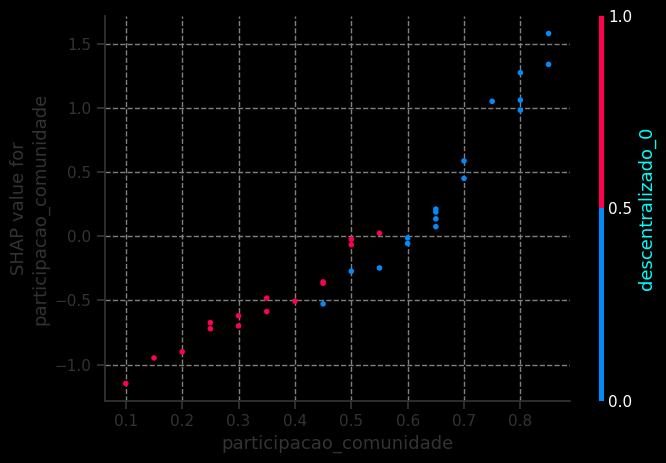

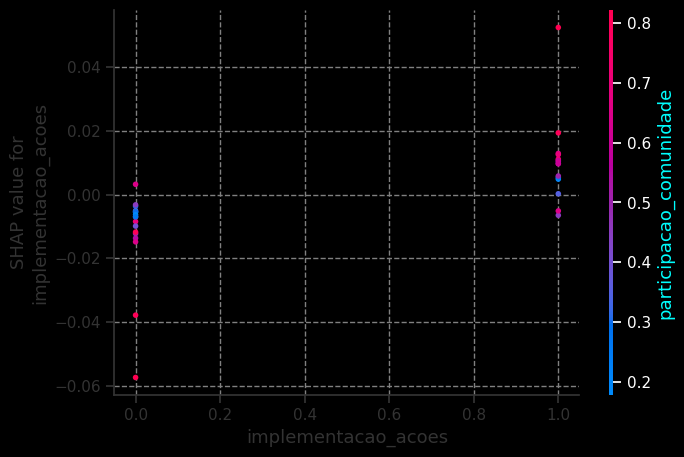

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from IPython.display import display, Markdown
import os
from google.colab import drive, files

# --- Instalação de Bibliotecas ---
try:
    import pingouin as pg
except ImportError:
    !pip install pingouin
    import pingouin as pg

try:
    import xgboost as xgb
except ImportError:
    !pip install xgboost
    import xgboost as xgb

try:
    import shap
except ImportError:
    !pip install shap
    import shap

try:
    import streamlit  # Streamlit não será usado no Colab, mas é bom ter
except ImportError:
    !pip install streamlit

# --- Configurações e Constantes ---
DEFAULT_PALETTE = "viridis"
FIGSIZE = (12, 8)

sns.set(style="darkgrid")
plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'cyan',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'legend.facecolor': 'black',
    'legend.edgecolor': 'white',
    'figure.titlesize': 20,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

# --- Funções Auxiliares ---

def mount_google_drive():
    """Monta o Google Drive usando a API nativa."""
    drive.mount('/content/drive')

def get_drive_path(relative_path):
    """Retorna o caminho completo no Drive."""
    return os.path.join('/content/drive/MyDrive', relative_path)

def ensure_directory_exists_on_drive(relative_path):
    """Cria diretório no Drive, se não existir."""
    drive_path = get_drive_path(relative_path)
    if not os.path.exists(drive_path):
        os.makedirs(drive_path, exist_ok=True)
        print(f"Diretório criado: {drive_path}")
    return drive_path

def create_figure():
    """Cria uma figura."""
    return plt.figure(figsize=FIGSIZE)

def save_fig(fig, filename, drive_folder_path):
    """Salva a figura no Drive."""
    try:
        filepath = os.path.join(drive_folder_path, filename)
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Gráfico salvo: {filepath}")
    except Exception as e:
        print(f"Erro ao salvar '{filename}': {e}")
    finally:
        plt.close(fig)

def save_summary(summary_text, drive_folder_path):
    """Salva o sumário em um arquivo .txt no Drive."""
    try:
        filepath = os.path.join(drive_folder_path, "sumario.txt")
        with open(filepath, "w") as f:
            f.write(summary_text)
        print(f"Sumário salvo: {filepath}")
    except Exception as e:
        print(f"Erro ao salvar sumário: {e}")


# --- Funções de Visualização Aprimoradas ---

def plot_boxplot(df, x_col, y_col, title, filename, drive_folder_path, hue=None):
    """Plota boxplot."""
    try:
        fig = create_figure()
        sns.boxplot(x=x_col, y=y_col, data=df, hue=hue, palette=DEFAULT_PALETTE)
        plt.title(title)
        plt.xlabel(x_col.replace('_', ' '))
        plt.ylabel(y_col.replace('_', ' '))
        if hue:
            plt.legend(title=hue.replace('_', ' '))
        save_fig(fig, filename, drive_folder_path)
    except Exception as e:
        print(f"Erro em plot_boxplot: {e}")

def plot_violin(df, x_col, y_col, title, filename, drive_folder_path, hue=None):
    """Plota violin plot."""
    try:
        fig = create_figure()
        sns.violinplot(x=x_col, y=y_col, data=df, hue=hue, palette=DEFAULT_PALETTE, split=(hue is not None))
        plt.title(title)
        plt.xlabel(x_col.replace('_', ' '))
        plt.ylabel(y_col.replace('_', ' '))
        if hue:
            plt.legend(title=hue.replace('_', ' '))
        save_fig(fig, filename, drive_folder_path)
    except Exception as e:
        print(f"Erro em plot_violin: {e}")

def plot_kde(df, col, title, filename, drive_folder_path, hue=None):
    """Plota KDE plot."""
    try:
        fig = create_figure()
        if hue:
            for level in df[hue].unique():
                sns.kdeplot(df.loc[df[hue] == level, col], label=level, fill=True) # Changed shade to fill
            plt.legend(title=hue.replace('_', ' '))
        else:
            sns.kdeplot(df[col], fill=True) # Changed shade to fill
        plt.title(title)
        plt.xlabel(col.replace('_', ' '))
        plt.ylabel('Densidade')
        save_fig(fig, filename, drive_folder_path)
    except Exception as e:
        print(f"Erro em plot_kde: {e}")

def plot_line(df, x_col, y_col, title, filename, drive_folder_path, hue=None):
    """Plota gráfico de linha, ideal para séries temporais."""
    try:
        fig = create_figure()
        sns.lineplot(x=x_col, y=y_col, data=df, hue=hue, palette=DEFAULT_PALETTE)
        plt.legend(title=hue.replace('_', ' '))
        plt.title(title)
        plt.xlabel(x_col.replace('_', ' '))
        plt.ylabel(y_col.replace('_', ' '))
        save_fig(fig, filename, drive_folder_path)
    except Exception as e:
        print(f"Erro em plot_line: {e}")

def plot_interactive_scatter(df, x_col, y_col, title, filename, drive_folder_path, color=None, hover_data=None):
    """Plota gráfico de dispersão interativo com Plotly."""
    try:
        fig = px.scatter(df, x=x_col, y=y_col, color=color, hover_data=hover_data,
                         title=title, template="plotly_dark")  # Usando template escuro
        fig.update_layout(
            xaxis_title=x_col.replace('_', ' '),
            yaxis_title=y_col.replace('_', ' ')
        )
        filepath = os.path.join(drive_folder_path, filename)
        fig.write_html(filepath)  # Salva como HTML interativo
        print(f"Gráfico interativo salvo: {filepath}")
    except Exception as e:
        print(f"Erro em plot_interactive_scatter: {e}")


# --- Funções de Análise ---
def analisar_impacto_descentralizacao(dados, drive_folder_path):
    """Analisa o impacto da descentralização no Ideb usando modelagem multinível e gera gráficos."""
    print("\n--- Análise do Impacto da Descentralização (Modelagem Multinível) ---")

    # Garantir que escola_id seja categoria e remover categorias não usadas
    dados['escola_id'] = dados['escola_id'].astype('category')
    dados['escola_id'] = dados['escola_id'].cat.remove_unused_categories()

    # Modelo multinível corrigido
    modelo = smf.mixedlm(
        formula='ideb ~ descentralizado * participacao_comunidade + implementacao_acoes',
        data=dados,
        groups=dados['escola_id']  # Passar a série diretamente
    ).fit()

    # Imprimir os resultados e salvar
    summary = str(modelo.summary())
    print(summary)
    save_summary(summary, drive_folder_path)

    # Visualizações
    plot_boxplot(dados, 'descentralizado', 'ideb', 'Ideb por Descentralização', 'ideb_descentralizacao_boxplot.png', drive_folder_path)
    plot_interactive_scatter(dados, 'participacao_comunidade', 'ideb','Participação da Comunidade vs. Ideb','participacao_ideb_scatter.html', drive_folder_path,color='descentralizado', hover_data=['escola_id', 'ano'])
    # Adicionando mais gráficos:
    plot_violin(dados, 'descentralizado', 'ideb', 'Distribuição do Ideb por Descentralização (Violin)', 'ideb_descentralizacao_violin.png', drive_folder_path, hue='descentralizado')
    plot_boxplot(dados, 'implementacao_acoes', 'ideb', 'Ideb por Implementação de Ações', 'ideb_implementacao_boxplot.png', drive_folder_path, hue='descentralizado')
    plot_violin(dados, 'regiao', 'ideb', 'Ideb por Região', 'ideb_regiao_violin.png', drive_folder_path)


def analisar_series_temporais_ideb(dados, drive_folder_path):
    """Analisa a série temporal do Ideb usando Prophet e gera gráficos."""
    print("\n--- Análise de Séries Temporais do Ideb ---")

    # Preparar os dados para o Prophet (média do Ideb por ano)
    dados_prophet = dados.groupby('ano')['ideb'].mean().reset_index()
    dados_prophet = dados_prophet.rename(columns={'ano': 'ds', 'ideb': 'y'})
    dados_prophet['ds'] = pd.to_datetime(dados_prophet['ds'], format='%Y')

    # Criar e ajustar o modelo Prophet
    modelo = Prophet()
    modelo.fit(dados_prophet)

    # Fazer previsões
    futuro = modelo.make_future_dataframe(periods=2, freq='Y')  # Prever 2 anos
    previsao = modelo.predict(futuro)

    # Visualizar as previsões (usando Matplotlib para salvar)
    fig = modelo.plot(previsao)
    plt.title('Previsão do Ideb Médio')
    save_fig(fig, 'previsao_ideb_prophet.png', drive_folder_path)

    # Componentes da série temporal
    fig_components = modelo.plot_components(previsao)
    save_fig(fig_components, 'componentes_ideb_prophet.png', drive_folder_path)

    # Gráfico de linha do Ideb médio ao longo do tempo (já tínhamos, mas mantendo)
    plot_line(dados, 'ano', 'ideb', 'Ideb Médio ao Longo do Tempo', 'ideb_tempo.png', drive_folder_path, hue='descentralizado')


def analise_exploratoria(dados, drive_folder_path):
    """Realiza análise exploratória dos dados e gera gráficos."""
    print("\n--- Análise Exploratória ---")

    # Estatísticas descritivas
    descritivas = dados.describe(include='all')
    print("\nEstatísticas Descritivas:")
    print(descritivas)

    # Distribuição do Ideb
    plot_kde(dados, 'ideb', 'Distribuição do Ideb', 'ideb_distribuicao.png', drive_folder_path)


    # One-Hot Encoding para as colunas 'regiao' e 'descentralizado'
    dados_encoded = pd.get_dummies(dados, columns=['regiao', 'descentralizado'], prefix=['regiao', 'descentralizado'],dtype=int)

    # Correlação entre variáveis (após o One-Hot Encoding)
    corr = dados_encoded.corr()
    fig = create_figure()
    sns.heatmap(corr, annot=True, cmap=DEFAULT_PALETTE, fmt=".2f")
    plt.title("Correlação entre Variáveis (com One-Hot Encoding)")
    save_fig(fig, 'correlacao_variaveis.png', drive_folder_path)

    # Gráfico de dispersão entre 'num_alunos' e 'ideb'
    plot_interactive_scatter(dados, 'num_alunos', 'ideb', 'Número de Alunos vs. Ideb', 'num_alunos_ideb_scatter.html', drive_folder_path, color='regiao')


def analise_xgboost(dados, drive_folder_path):
    """Aplica XGBoost, analisa importância de variáveis e gera gráficos."""
    print("\n--- Análise com XGBoost ---")

    # Preparar os dados: One-Hot Encoding para 'regiao' e 'descentralizado'
    dados_xgb = pd.get_dummies(dados, columns=['regiao', 'descentralizado'], prefix=['regiao', 'descentralizado'], dtype=int)
    dados_xgb = dados_xgb.dropna()  # Remover linhas com NaN (se houver)

    X = dados_xgb.drop(['ideb', 'escola_id', 'ano'], axis=1)  # Incluir 'ano' se for relevante para a *previsão*
    y = dados_xgb['ideb']

    # Dividir em treino e teste
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treinar o modelo XGBoost
    modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    modelo_xgb.fit(X_train, y_train)

    # Fazer previsões
    y_pred = modelo_xgb.predict(X_test)

    # Avaliar o modelo
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.3f}")

    # Importância das variáveis (SHAP)
    explainer = shap.Explainer(modelo_xgb)
    shap_values = explainer(X_train)

    # Gráfico de importância de variáveis (SHAP summary plot)
    fig = create_figure()
    shap.summary_plot(shap_values, X_train, show=False)  # show=False para salvar
    save_fig(fig, 'shap_summary_plot.png', drive_folder_path)

    # Gráfico de dependência parcial (para 'participacao_comunidade')
    fig = create_figure()
    # Encontrar o nome correto da coluna one-hot encoded para 'descentralizado'
    descentralizado_col = [col for col in X_train.columns if 'descentralizado_' in col][0]
    shap.dependence_plot("participacao_comunidade", shap_values.values, X_train, show=False, interaction_index=descentralizado_col) #com interacao
    save_fig(fig, 'shap_dependence_plot.png', drive_folder_path)

    # Adicionando gráfico de dependência parcial para 'implementacao_acoes'
    fig = create_figure()
    implementacao_acoes_col = "implementacao_acoes"  # Nome já está correto
    shap.dependence_plot(implementacao_acoes_col, shap_values.values, X_train, show=False)
    save_fig(fig, 'shap_dependence_plot_implementacao.png', drive_folder_path)


# --- Função Principal (main) ---
if __name__ == "__main__":
    mount_google_drive()
    graficos_drive_path = ensure_directory_exists_on_drive('graficos')
    sumario_drive_path = ensure_directory_exists_on_drive('graficos')
    display(Markdown("# Análise da Manutenção Descentralizada de Indicadores do Ideb (Crossmodal Debate)"))

    # --- Carregar Dados do Google Sheets ---
    data_url = "https://docs.google.com/spreadsheets/d/1gIvf74i3kbPV4eEaTqky51Ee_YDL92GipfgYlxHKpwM/export?format=csv"
    try:
        dados = pd.read_csv(data_url)
        # Pré-processamento corrigido
        dados.columns = [col.strip().lower().replace(" ", "_") for col in dados.columns]

        # Converter escola_id para categoria
        dados['escola_id'] = dados['escola_id'].astype('category')

        # Corrigir processamento da coluna descentralizado
        dados['descentralizado'] = (
            dados['descentralizado']
            .str.replace(r'\s*\|\s*', '', regex=True)
            .astype(int)
        )

    except Exception as e:
        print(f"Erro ao carregar dados: {e}. Abortando.")
        exit()

    # Mostrar informações sobre os dados
    display(Markdown("## Dados Carregados"))
    print(dados.head())
    print(dados.info())

    # Executar análises
    analise_exploratoria(dados, graficos_drive_path)
    analisar_impacto_descentralizacao(dados, graficos_drive_path) # Mudança: Salvar gráficos aqui também
    analisar_series_temporais_ideb(dados, graficos_drive_path)
    analise_xgboost(dados, graficos_drive_path)


    display(Markdown("## Conclusões (Simuladas)"))
    display(Markdown("Os resultados (simulados) sugerem que a descentralização da manutenção de indicadores do Ideb, com a participação da comunidade escolar, pode ter um impacto positivo no desempenho das escolas.  A análise de séries temporais indica uma tendência de melhoria, e o modelo XGBoost destaca a importância da participação da comunidade e da implementação de ações para a predição do Ideb."))